# GPS signal
This captures an GPS signal of a specified duration, find the correlation in simple way.

In [106]:
4+2 # Test if kernel is running

6

In [107]:
import time
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
import math
from copy import copy
np.set_printoptions(precision=2)

In [108]:
# Set up the SDR
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr 
# Close previous instances of the sdr object
try: 
    sdr.close()
except NameError:
   pass

In [109]:
sdr = RtlSdr() # Create a new sdr object (by keeping this in 
               # the block above can be used to close sdr without
               # creating a new sdr instance, which you might want to
               # do when switching to a new program
               # If this fails, try 
               # (1) running close block above
               # (2) closing other programs that may be using SDR
               # (3) restart this kernel

In [110]:
fsps = 2*256*256*16 # =  about 2Msps

fc = 1575.42e6 # GPS frequenzy

# specify sampling frequency
dt = 1.0/fsps # time step size between samples
nyquist = fsps /2.0

Tmax = 0.0625        # 0.0625 s This should be enough to cover at least one whole word.

N = round(fsps*Tmax) # N must be a multiple of 256
print("The number of samples to collect, N= ",N)

sdr.sample_rate = fsps 
sdr.center_freq = fc

print("The valid gains are")
print(sdr.valid_gains_db)
#sdr.gain = 'auto'
sdr.gain = 42.0 # This is max, according to sdr.valid_gains_db
print("We are using ")
print("Gain (0==auto)  : ", sdr.gain)
print("Sample Rate     : ", sdr.sample_rate)
print("Center frequency: ", sdr.center_freq)

The number of samples to collect, N=  131072
The valid gains are
[-1.0, 1.5, 4.0, 6.5, 9.0, 11.5, 14.0, 16.5, 19.0, 21.5, 24.0, 29.0, 34.0, 42.0]
We are using 
Gain (0==auto)  :  42.0
Sample Rate     :  2097152.0
Center frequency:  1575420000


In [111]:
# Collect some noise (to be used when measuring Signal to Noise
# ratio)
noisesamples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
fnoise = 80e6
sdr.center_freq = fnoise # outside of FM band...should be empty
print("Sampling with center frequency ", fnoise, " for ", Tmax, " seconds")
print("Frequency spans from ", (fnoise-nyquist)/1e6," to ", (fnoise+nyquist)/1e6,"MHz")
print("SDR gain:", sdr.gain)
noisesamples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256

noisespectrum = np.fft.fftshift(np.fft.fft(noisesamples))
noisepowerfd = np.sum(np.real(noisespectrum*noisespectrum.conjugate()))
noisepowerperhzfd = noisepowerfd / nyquist
noisepowerperbinfd = noisepowerfd / len(noisesamples)

print("Total noise power (from freq domain) =", noisepowerfd)
print("Total noise power / Hz (from freq domain) = ", noisepowerperhzfd)
print("Total noise power / bin (from freq domain) = ", noisepowerperbinfd)


sdr.center_freq = fc # set it back to main frequency of interest


Sampling with center frequency  80000000.0  for  0.0625  seconds
Frequency spans from  78.951424  to  81.048576 MHz
SDR gain: 42.0
Total noise power (from freq domain) = 1559439.3245674646
Total noise power / Hz (from freq domain) =  1.487197231833901
Total noise power / bin (from freq domain) =  11.897577854671209


In [112]:
#***
# Collect samples
samples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
print("Sampling with center frequency ", fc, " for ", Tmax, " seconds")
sdr.center_freq = fc
print("Frequency spans from ", (fc-nyquist)/1e6," to ", (fc+nyquist)/1e6,"MHz")

print("SDR gain:", sdr.gain)

RF_record_start_time = time.time()
samples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256end_time = time.time()
RF_record_end_time = time.time()
RF_record_duration_actual = RF_record_end_time - RF_record_start_time
print("Actual time duration of RF recording: ",RF_record_duration_actual)

Sampling with center frequency  1575420000.0  for  0.0625  seconds
Frequency spans from  1574.371424  to  1576.468576 MHz
SDR gain: 42.0
Actual time duration of RF recording:  0.06435513496398926


Commanded samples per second= 2097152
Actual samples per second=  2036698.3935834027


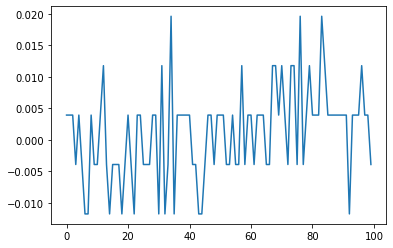

In [113]:
# Check that actual RF sampling rate is close to what we intend
# At high commanded sampling rates (eg 3Msps) there is a problem
# and these diverge
print("Commanded samples per second=", fsps)
print("Actual samples per second= ", N/RF_record_duration_actual)
plt.plot(range(100), np.real(samples[0:100]))

For band from  1574.371424  to  1576.468576 MHz,
 max is 35.0 dB, at  1575.420008000061 MHz (index  65536 )


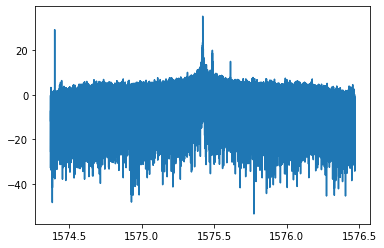

In [114]:
#***
# Compute and plot the spectrum for the samples just collected
freqs = np.zeros((N))
spectrum = ((np.zeros((N))+1j)-1j)
maxval = 0.0
maxind = 0.0

plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
maxval = np.amax(np.abs(spectrum))
maxindi = np.argmax(np.abs(spectrum))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
plt.plot(freqs/1e6,10*np.log10(np.real(spectrum*spectrum.conjugate())/noisepowerperbinfd))
print("For band from ", (fc-nyquist)/1e6, " to ",(fc+nyquist)/1e6, "MHz,")
print(" max is", round(10*np.log10((maxval**2)/noisepowerperbinfd)), "dB, at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")

In [115]:
#***
# The C/A signal covers around 2MHz, so we shouldn't filter this.
filteredsignal = np.fft.ifft(np.fft.fftshift(spectrum)) # Good results

# C/A code generation

In [116]:
def LFSR(N, initial, feedback):
    res = np.array([(initial >> (feedback.bit_length()-2)) & 1])
    for i in range(N-1):
        initial <<= 1
        mask = initial & feedback
        for j in range(feedback.bit_length()):
            mask = (mask >> 1) ^ (mask & 1)
        initial = (initial & ((1 << (feedback.bit_length())) -1 ) ) | mask
        res = np.append(res, (initial >> (feedback.bit_length()-2)) & 1)
    return res

In [117]:
G1 = LFSR(1033, 0b1111111111, 0b10000001001) # Gold code 1
G2 = LFSR(1033, 0b1111111111, 0b11101001101) # Gold code 2

SV = {      # Phase selection
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

prn = 6 # Change this for different prn signal

CA = np.array([])

for i in range(1023):
    CA = np.append (CA, G1[i] ^ G2[i+10-SV[prn][0]] ^ G2[i+10-SV[prn][1]]) # Combined signal
print(G1[:20])
print(G2[:20])
print(CA[:40])

[1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1]
[1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0]
[1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]


Create the C/A code that match with the sample rate of the samples.

2098


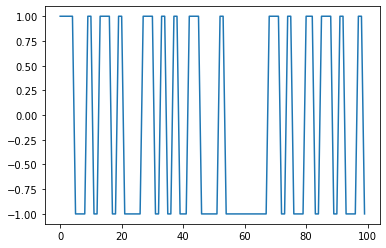

In [118]:
alteredCA = np.zeros(N)
for i in range(N):
    T = i / fsps
    index = math.floor(T*1000*1023)
    if (index >= 1023):
        break
    elif (CA[index%1023] == 0):
        alteredCA[i] = -1
    else:
        alteredCA[i] = 1
alteredCA = alteredCA[:i]
CAsignal = alteredCA
#CAsignal = np.multiply(alteredCA, np.real(carrier[:alteredCA.shape[0]]))
plt.plot(range(100),np.real(CAsignal[:100]))
print(alteredCA.shape[0]);
CAsignal_n = CAsignal / np.sqrt(np.dot(CAsignal, CAsignal))

Find the frequency domain of the C/A code.

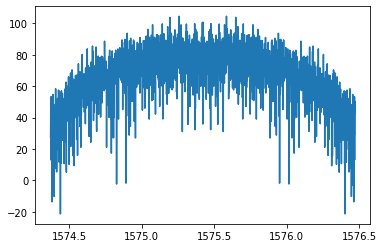

In [119]:
caspectrum = np.fft.fftshift(np.fft.fft(CAsignal))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(caspectrum))
plt.plot(freqs/1e6,10*np.log(np.real(caspectrum*caspectrum.conjugate())))

Create the C/A code that match with four times the sample rate of the samples. This is to investigate the frequency domain if it matched the theory or not.

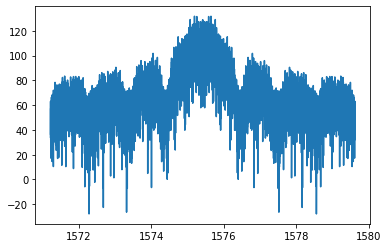

In [120]:
alteredHighSampleCA = np.zeros(N)
for i in range(N):
    T = i / fsps/4
    index = math.floor(T*1000*1023)
    if (index >= 1023):
        break
    elif (CA[index%1023] == 0):
        alteredHighSampleCA[i] = -1
    else:
        alteredHighSampleCA[i] = 1
alteredHighSampleCA = alteredHighSampleCA[:i]
CAHighSample = alteredHighSampleCA
caspectrum = np.fft.fftshift(np.fft.fft(CAHighSample))
freqs = np.linspace(fc-nyquist*4,fc+nyquist*4,len(caspectrum))
plt.plot(freqs/1e6,10*np.log(np.real(caspectrum*caspectrum.conjugate())))

# Correlation
Generate synthetic signal to test the correlation.

In [121]:
alteredCA = np.zeros(N)
for i in range(N):
    T = i / fsps
    index = math.floor(T*1000*1023)
    if (CA[index%1023] == 0):
        alteredCA[i] = -1
    else:
        alteredCA[i] = 1
alteredCA = alteredCA[:i]
#Synsignal = np.multiply(alteredCA, np.real(carrier[:alteredCA.shape[0]]))
Synsignal = alteredCA
print(alteredCA.shape[0]);
Synsignal_n = Synsignal / np.sqrt(np.dot(Synsignal, Synsignal))

131071


Run Correlation on synthetic signal.

In [122]:
correlate = np.zeros(Synsignal.shape[0]-CAsignal.shape[0]+1)
for i in range(Synsignal.shape[0]-CAsignal.shape[0]+1):
    trun_sig = np.real(Synsignal_n[i: i+ CAsignal.shape[0]])
    signal_n = trun_sig / np.sqrt(np.dot(trun_sig, trun_sig))
    correlate[i] = np.dot(signal_n, CAsignal_n)

0.9999999999999752


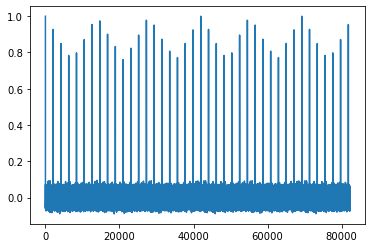

In [123]:
plt.plot(range(41089*2), correlate[0:41089*2])
print (max(correlate))

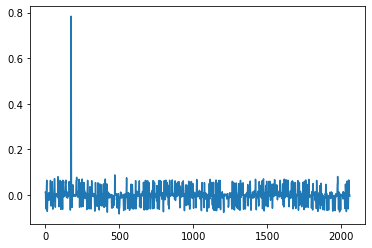

In [124]:
plt.plot(range(2059), correlate[6118:8177])

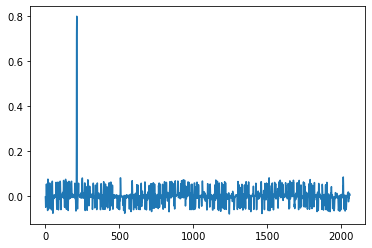

In [125]:
plt.plot(range(2059), correlate[8177:10236])

Run correlation on real signal.

In [131]:
correlate = np.zeros(samples.shape[0]-CAsignal.shape[0]+1)
for i in range(filteredsignal.shape[0]-CAsignal.shape[0]+1):
    trun_sig = np.real(samples[i: i+ CAsignal.shape[0]])
    signal_n = trun_sig / np.sqrt(np.dot(trun_sig, trun_sig))
    correlate[i] = np.dot(signal_n, CAsignal_n)

0.1139831223852503


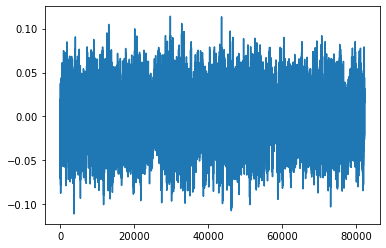

In [132]:
plt.plot(range(41089*2), correlate[0:41089*2])
print (max(correlate))

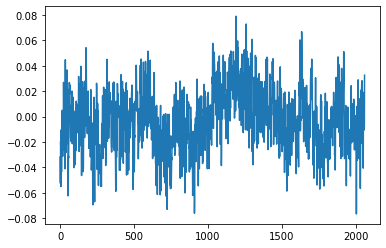

In [133]:
plt.plot(range(2059), correlate[6118:8177])

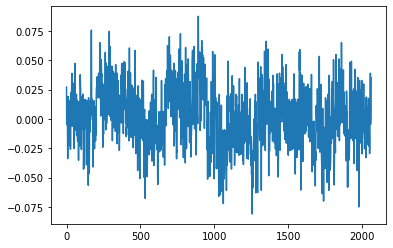

In [134]:
plt.plot(range(2059), correlate[8177:10236])